# Build and evalulate our model

We'll now import the latitude, longitude and weather data we collected and saved as pickle variables with the collect_and_clean_data.ipynb notebook

## Import required packages and cleaned variables

In [1]:
import numpy as np
import pandas as pd
from tabulate import tabulate
from sklearn import metrics
import tensorflow as tf
import pickle
import inspect
import re

tf.set_random_seed(123) # Control the randomization of tensorflow
np.random.seed(123) #Control randomization 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Import the elevation and weather data as a pickle file
Note: I imported the value as a pickle since it was easier to grab the nested arrays in cells out of that that than the csv which import as strings

In [2]:
with open('california_vineyards_elevation_weather.pkl', 'rb') as f: 
    elevation_weather_df = pickle.load(f)
    
#convert rows from a given column into a numpy array
def rows_to_2D_array(col):
    for i, row in enumerate(col):
        if i == 0:
            arr = ([row])
        else:
            arr = np.vstack([arr,row])
    return arr

#convert rows from a given column into a numpy array
def rows_to_3D_array(col):
    for i, row in enumerate(col):
        if i == 0:
            arr = np.array([row[0]])
        else:
            arr = np.concatenate([arr, np.array([row[0]])], axis=0)
    return arr

is_vineyard = np.array(elevation_weather_df['IsVineyard']).astype(float)
map_coords = rows_to_2D_array(elevation_weather_df['MapCoords'])
elevation = rows_to_3D_array(elevation_weather_df['ElevationMatrix'])
wind_dir = rows_to_2D_array(elevation_weather_df['WindDir'])
wind_spd = rows_to_2D_array(elevation_weather_df['WindSpd'])
precip = rows_to_2D_array(elevation_weather_df['Precip'])
temp = rows_to_2D_array(elevation_weather_df['Temp'])
min_temp = rows_to_2D_array(elevation_weather_df['MinTemp'])
max_temp = rows_to_2D_array(elevation_weather_df['MaxTemp'])
clouds = rows_to_2D_array(elevation_weather_df['Clouds'])
ghi = rows_to_2D_array(elevation_weather_df['GHI'])
rh = rows_to_2D_array(elevation_weather_df['RH'])

## Clean missing data
Convert all missing values to the mean of each variable

In [3]:
#Replace missing values with mean of array
def replace_none(array):
    for subarray in array:
        subarray[subarray == None] = np.mean(subarray[subarray != None])

replace_none([map_coords, elevation, wind_dir, wind_spd, precip, temp, min_temp, max_temp, clouds, ghi, rh])

## Reserve portion of data for test set
Choose the number of addresses we want to leave as our test set. We use a stratified 80-20 split. 

In [4]:
from sklearn.model_selection import train_test_split

el_aux = elevation[:, :, :, np.newaxis]

X = {'elevation': el_aux, 'map_coords': map_coords,
     'wind_dir': wind_dir,
     'precip': precip,
     'min_temp': min_temp,
     'max_temp': max_temp, 'clouds': clouds, 'ghi': ghi, 'rh': rh}

trX_index, tsX_index, _, _ = train_test_split(np.arange(len(list(X.items())[0][1])), is_vineyard,
                                              stratify=is_vineyard, test_size=0.1, shuffle=True,
                                              random_state=42)

trX = {k: l[trX_index] for k, l in X.items()}
trY = is_vineyard[trX_index]

tsX = {k: l[tsX_index] for k, l in X.items()}
tsY = is_vineyard[tsX_index]

## Train the models.

We train two versions:

* One following the previously defined architecture.
* One that uses 1D convolution to model time that reduces the number of parameters to learn while keeping the predictive performance at good levels. Thus, this parametrization should promote higher generalization power.

In [5]:
import importlib
import models

models = importlib.reload(models)

Using TensorFlow backend.


In [6]:
conv_clf = models.VineyardClassifier().fit(trX, trY)

Train on 647 samples, validate on 162 samples
Epoch 1/100
 - 1s - loss: 0.6829 - acc: 0.6105 - val_loss: 0.5519 - val_acc: 0.7099

Epoch 00001: val_loss improved from inf to 0.55185, saving model to conv_weights.hdf5
Epoch 2/100
 - 0s - loss: 0.5863 - acc: 0.7110 - val_loss: 0.6102 - val_acc: 0.7531

Epoch 00002: val_loss did not improve
Epoch 3/100
 - 0s - loss: 0.5538 - acc: 0.7403 - val_loss: 0.5147 - val_acc: 0.7407

Epoch 00003: val_loss improved from 0.55185 to 0.51466, saving model to conv_weights.hdf5
Epoch 4/100
 - 0s - loss: 0.5293 - acc: 0.7481 - val_loss: 0.8354 - val_acc: 0.6111

Epoch 00004: val_loss did not improve
Epoch 5/100
 - 0s - loss: 0.5497 - acc: 0.7434 - val_loss: 0.7631 - val_acc: 0.6420

Epoch 00005: val_loss did not improve
Epoch 6/100
 - 0s - loss: 0.5383 - acc: 0.7388 - val_loss: 0.5974 - val_acc: 0.7469

Epoch 00006: val_loss did not improve
Epoch 7/100
 - 0s - loss: 0.5144 - acc: 0.7728 - val_loss: 0.5314 - val_acc: 0.7469

Epoch 00007: val_loss did not i


Epoch 00063: val_loss did not improve
Epoch 64/100
 - 0s - loss: 0.4443 - acc: 0.8130 - val_loss: 0.4826 - val_acc: 0.7963

Epoch 00064: val_loss did not improve
Epoch 65/100
 - 0s - loss: 0.4522 - acc: 0.8053 - val_loss: 0.5234 - val_acc: 0.8025

Epoch 00065: val_loss did not improve
Epoch 66/100
 - 0s - loss: 0.4434 - acc: 0.8053 - val_loss: 0.4803 - val_acc: 0.8086

Epoch 00066: val_loss did not improve
Epoch 67/100
 - 0s - loss: 0.4510 - acc: 0.8022 - val_loss: 0.4820 - val_acc: 0.8025

Epoch 00067: val_loss did not improve
Epoch 68/100
 - 0s - loss: 0.4498 - acc: 0.7991 - val_loss: 0.4826 - val_acc: 0.8086

Epoch 00068: val_loss did not improve
Epoch 69/100
 - 0s - loss: 0.4372 - acc: 0.8083 - val_loss: 0.4863 - val_acc: 0.7901

Epoch 00069: val_loss did not improve
Epoch 70/100
 - 0s - loss: 0.4337 - acc: 0.8068 - val_loss: 0.5549 - val_acc: 0.7654

Epoch 00070: val_loss did not improve
Epoch 71/100
 - 0s - loss: 0.4414 - acc: 0.8083 - val_loss: 0.4956 - val_acc: 0.7778

Epoch 0

## Model Assessment

Evaluate the model performance using: accuracy, F1-score, the area under the Receiver Operating Curve and the Precision-Recall curve. As can be seen below, the proposed model was able to improve the probability estimation of the model.

In [20]:
def evaluate_model(model, X, y):
    probs = model.predict_proba(X)[:, 1]
    preds = probs.round().astype(np.int)

    all_metrics = [('Accuracy', metrics.accuracy_score, False),
                   ('F1', metrics.f1_score, False),
                   ('ROC AUC', metrics.roc_auc_score, True),
                   ('PR AUC', metrics.average_precision_score, True),
                   ]

    for name, metric, needs_proba in all_metrics:
        if needs_proba:
            next_result = metric(y, probs)
        else:
            next_result = metric(y, preds)

        print('%15s %10.4f' % (name, 100 * next_result))

print('Convolutional model')
evaluate_model(conv_clf, tsX, tsY)
print()

Convolutional model
       Accuracy    92.2222
             F1    91.7647
        ROC AUC    97.6779
         PR AUC    97.8492



Plot the training/validation loss and accuracy for each model.

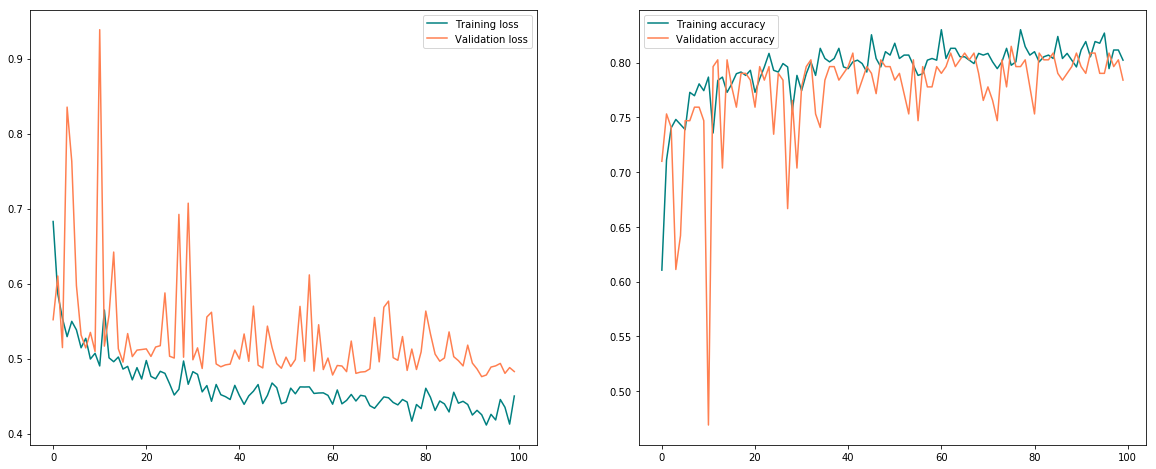

In [8]:
from matplotlib import pyplot as plt

def plot_learning_curves(clf):
    probs = clf.predict_proba(tsX)[:, 1]

    #Plot performance over epochs
    
    #Create ticks on x axis from 0 through the number of epochs
    x = np.arange(0, len(clf.history['loss']))

    lines = [clf.history['loss'],clf.history['val_loss']]
    colors  = ['teal','coral']
    labels  = ['Training loss','Validation loss']

    # Adjust default plot size
    plt.figure(figsize=(20, 8))
    plt.subplot(121)

    for i,c,l in zip(lines,colors,labels):
        plt.plot(x,i,c,label='l')
        plt.legend(labels)

    lines = [clf.history['acc'],clf.history['val_acc']]
    colors  = ['teal','coral']
    labels  = ['Training accuracy','Validation accuracy']

    # Adjust default plot size
    plt.subplot(122)
    for i,c,l in zip(lines,colors,labels):  
        plt.plot(x,i,c,label='l')
        plt.legend(labels)
    plt.show()

plot_learning_curves(conv_clf)

Plot the ROC and Precision-Recall curves.

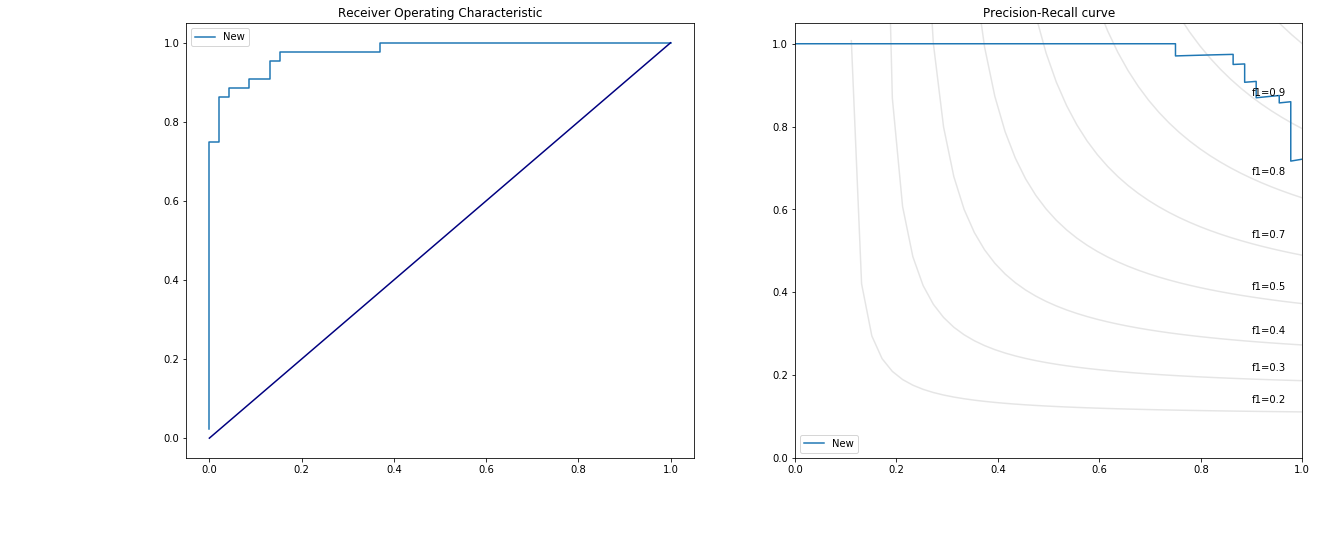

In [9]:
from sklearn.metrics import roc_curve, precision_recall_curve

def plot_performance_curves(clfs, tsX, tsY):
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    for name, clf in clfs:
        probs = clf.predict_proba(tsX)[:, 1]
        fpr, tpr, thresholds = roc_curve(tsY, probs)
        plt.plot(fpr, tpr, label=name)
    
    plt.plot([0, 1], [0, 1], color='navy')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='best')

    plt.subplot(122)
    f_scores = np.linspace(0.2, 1.0, num=8)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    for name, clf in clfs:
        probs = clf.predict_proba(tsX)[:, 1]
        precision, recall, _ = precision_recall_curve(tsY, probs)
        plt.plot(recall, precision, label=name)

    plt.title('Precision-Recall curve')
    plt.legend(loc='best')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

plot_performance_curves([('New', conv_clf)], tsX, tsY)